In [18]:
import os
import pickle
import re
import zipfile
from collections import Counter

import dill
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
df = pd.read_csv("D:\\MS sem 2\\NLP\\train.csv")
df_test = pd.read_csv("D:\\MS sem 2\\NLP\\test_labels.csv")
df_testcomments = pd.read_csv("D:\\MS sem 2\\NLP\\test.csv")

In [20]:
# obtain class labels of the dataset
class_labels = list(df.columns[2:])
class_labels

# remove rows with -1 from df_test as it is not used for scoring
print(f'Before removing -1: {df_test.shape}')
for class_label in class_labels:
    df_test = df_test[df_test[class_label] != -1]
print(f'After removing -1: {df_test.shape}')

# merge df_test and df_testcomments on id
df_test = pd.merge(df_test, df_testcomments, on='id', how='left')
# rearraange columns to be the same as df
df_test = df_test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

Before removing -1: (153164, 7)
After removing -1: (63978, 7)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


In [5]:
def preprocess_text(text):
    # remove extra spaces
    text = re.sub("\s\s+", " ", text)
    text = text.replace("\n", " ")
    # remove Non-English characters
    text = re.sub(r'[^\x00-\x7F]+', "", text)
    text = text.strip()
    # remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    # remove punctuations
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = text.lower()

    return text

def tokenize_text(documents):
    lemma_list = []
    for doc in nlp.pipe(documents, disable=["ner", "parser"], batch_size=1000):
        # Generate lemmatized tokens
        lemmatized_tokens = [token.lemma_ for token in doc]
        # Remove stop words and non-alphabetic characters
        lemmatized_tokens = [token for token in lemmatized_tokens
                             if token not in nlp.Defaults.stop_words
                             and token.isalpha()]
        lemma_list.append(lemmatized_tokens)

    return lemma_list

In [6]:
df['comment_text'] = df['comment_text'].apply(preprocess_text)
df.head(10)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more can t make any real suggestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tools...,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)
df_test.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank you for understanding think very highly ...,0,0,0,0,0,0
1,000247e83dcc1211,dear god this site is horrible,0,0,0,0,0,0
2,0002f87b16116a7f,somebody will invariably try to add religion ...,0,0,0,0,0,0
3,0003e1cccfd5a40a,it says it right there that it is type the ty...,0,0,0,0,0,0
4,00059ace3e3e9a53,before adding new product to the list make su...,0,0,0,0,0,0
5,000663aff0fffc80,this other one from 1897,0,0,0,0,0,0
6,000689dd34e20979,reason for banning throwing this article need...,0,0,0,0,0,0
7,000844b52dee5f3f,blocked from editing wikipedia,0,0,0,0,0,0
8,00091c35fa9d0465,arabs are committing genocide in iraq but no ...,1,0,0,0,0,0
9,000968ce11f5ee34,please stop if you continue to vandalize wikip...,0,0,0,0,0,0


In [8]:
nlp = spacy.load('en_core_web_sm')

# Define your tokenize_text function with debug prints
def tokenize_text(documents):
    print("Starting tokenization...")
    lemma_list = []
    batch_size = 1000  # Adjust batch size as needed
    
    # Process documents in batches
    for i in range(0, len(documents), batch_size):
        print(f"Processing batch {i//batch_size + 1}...")
        docs = list(nlp.pipe(documents[i:i+batch_size], disable=["ner", "parser"]))
        for doc in docs:
            lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
            lemma_list.append(lemmatized_tokens)
    
    print("Tokenization completed.")
    return lemma_list

In [17]:
tokenized_comment = tokenize_text(df['comment_text'].tolist())
tokenized_comment_test = tokenize_text(df_test['comment_text'].tolist())

# Get label for train and test data
y = df[class_labels]
y_test = df_test[class_labels]

Starting tokenization...
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processing batch 39...
Processing batch 40...
Processing batch 41...
Processing batch 42...
Processing batch 4

In [21]:
df_combined = pd.DataFrame({'comment': tokenized_comment,
                            'toxic': y['toxic'],
                            'severe_toxic': y['severe_toxic'],
                            'obscene': y['obscene'],
                            'threat': y['threat'],
                            'insult': y['insult'],
                            'identity_hate': y['identity_hate']})

df_combined_test = pd.DataFrame({'comment': tokenized_comment_test,
                                 'toxic': y_test['toxic'],
                                 'severe_toxic': y_test['severe_toxic'],
                                 'obscene': y_test['obscene'],
                                 'threat': y_test['threat'],
                                 'insult': y_test['insult'],
                                 'identity_hate': y_test['identity_hate']})

df_combined.head()

,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edit, username, hardcore, metall...",0,0,0,0,0,0
1,"[d, aww, match, background, colour, m, seeming...",0,0,0,0,0,0
2,"[hey, man, m, try, edit, war, s, guy, constant...",0,0,0,0,0,0
3,"[t, real, suggestion, improvement, wonder, sec...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page, s]",0,0,0,0,0,0


In [22]:
def graph_multilabel(df1,
                     title='Number of comments having multiple labels',
                     offset=500):# sum of all labels
    rowSums = df1.iloc[:, 2:].sum(axis=1)
    # count of comments having multiple labels
    multiLabel_counts = rowSums.value_counts()
    # remove count of comments having zero labels
    multiLabel_counts = multiLabel_counts[1:]
    # sort the index
    multiLabel_counts = multiLabel_counts.sort_index(ascending=True)

    sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)
    for i, v in enumerate(multiLabel_counts.values):
        plt.text(i - 0.2, v + offset, str(v), color='black', fontweight='bold')
    plt.title(title)
    plt.ylabel('Number of comments', fontsize=12)
    plt.xlabel('Number of labels', fontsize=12)
    plt.show()
    return multiLabel_counts

def get_class_info(df, df_combine, class_labels):
    class_info = {}
    for class_label in class_labels:
        data = df[df[class_label] == 1]
        num_sentences = data.shape[0]
        num_tokens = df_combine[df_combine[class_label]
                                == 1]['comment'].apply(len).sum()
        class_info[class_label] = {
            'num_sentences': num_sentences, 'num_tokens': num_tokens}
    return class_info


def plot_sent(class_info,
              title='Number of sentences per class in training data',
              label_offset=500):
    counts = [d['num_sentences'] for d in class_info.values()]
    plt.figure(figsize=(10, 8))
    sns.barplot(x=class_labels, y=counts)
    plt.title(title)
    for i, count in enumerate(counts):
        plt.text(i, count + label_offset, count, ha='center', va='top')
    plt.show()


def plot_tokens(class_info, title='Number of tokens per class in training data', label_offset=500):
    counts = [d['num_tokens'] for d in class_info.values()]
    plt.figure(figsize=(10, 8))
    sns.barplot(x=class_labels, y=counts)
    plt.title(title)
    for i, count in enumerate(counts):
        plt.text(i, count + label_offset, count, ha='center', va='top')
    plt.show()
    
def plot_common_words(counts, title):
    labels = [word for word, _ in counts]
    freqs = [count for _, count in counts]
    plt.figure(figsize=(10, 5))
    plt.bar(labels, freqs, color='blue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


In [23]:
# count of words per label
category_counts = df.iloc[:, 2:].sum()
print(category_counts)
print('\n')
category_counts_test = df_test.iloc[:, 2:].sum()
print(category_counts_test)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


toxic            6090
severe_toxic      367
obscene          3691
threat            211
insult           3427
identity_hate     712
dtype: int64


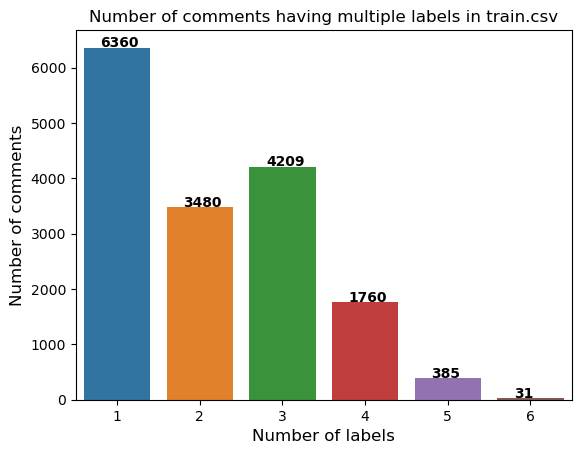

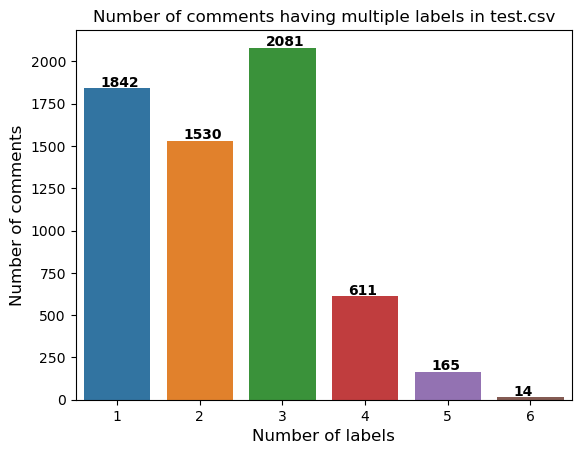

1    1842
2    1530
3    2081
4     611
5     165
6      14
dtype: int64

In [14]:
# plot number of comments having multiple labels
label_count = graph_multilabel(df,
                               title='Number of comments having multiple labels in train.csv',
                               offset=10)
graph_multilabel(
    df_test, title='Number of comments having multiple labels in test.csv', offset=10)


In [24]:
# get number of sentences and tokens for each class
train_info = get_class_info(df, df_combined, class_labels)
train_info

{'toxic': {'num_sentences': 15294, 'num_tokens': 403844},
 'severe_toxic': {'num_sentences': 1595, 'num_tokens': 73947},
 'obscene': {'num_sentences': 8449, 'num_tokens': 223875},
 'threat': {'num_sentences': 478, 'num_tokens': 13697},
 'insult': {'num_sentences': 7877, 'num_tokens': 201237},
 'identity_hate': {'num_sentences': 1405, 'num_tokens': 43083}}

In [25]:
test_info = get_class_info(df_test, df_combined_test, class_labels)
test_info

{'toxic': {'num_sentences': 6090, 'num_tokens': 141180},
 'severe_toxic': {'num_sentences': 367, 'num_tokens': 28932},
 'obscene': {'num_sentences': 3691, 'num_tokens': 96963},
 'threat': {'num_sentences': 211, 'num_tokens': 6569},
 'insult': {'num_sentences': 3427, 'num_tokens': 87812},
 'identity_hate': {'num_sentences': 712, 'num_tokens': 25097}}

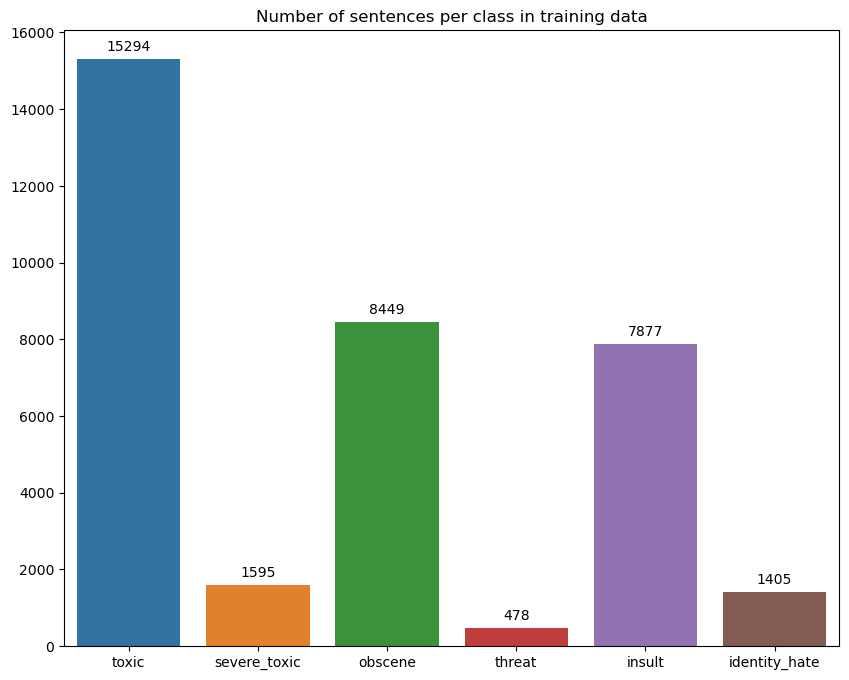

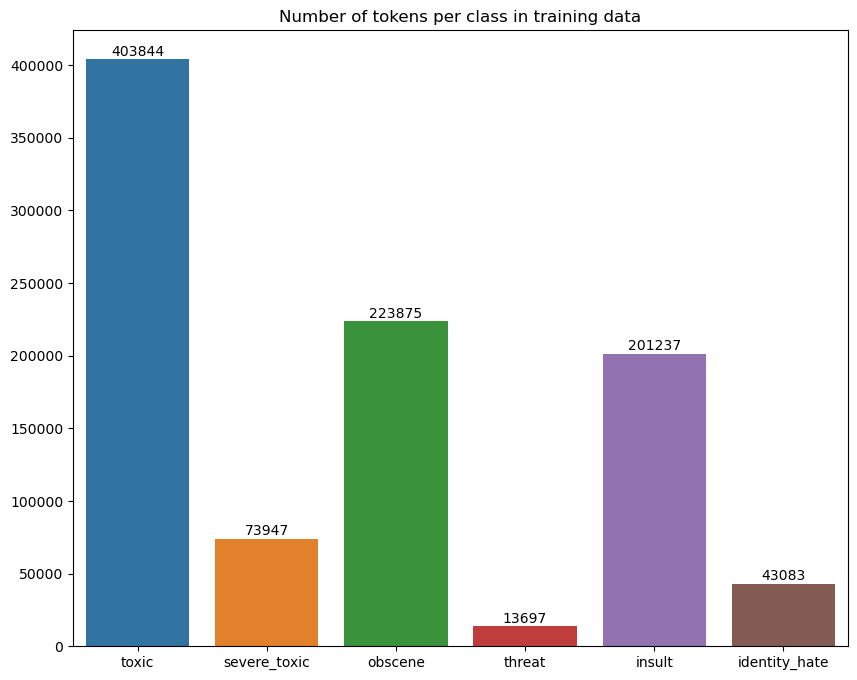

In [26]:
# Visualize the distributtion of the dataset
plot_sent(train_info, title='Number of sentences per class in training data')

# Visualize the distribution of number of tokens per class
plot_tokens(train_info, title='Number of tokens per class in training data', label_offset=10000)

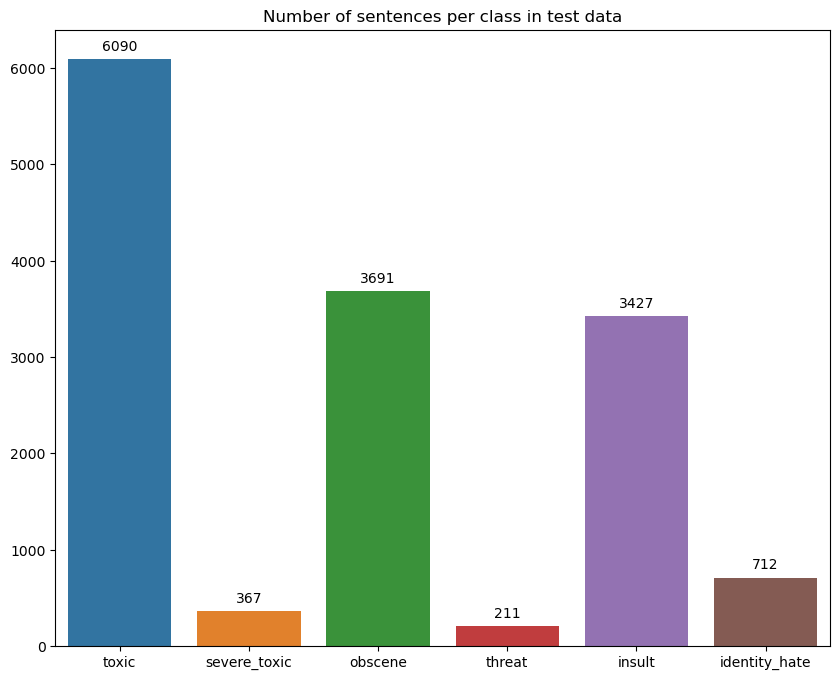

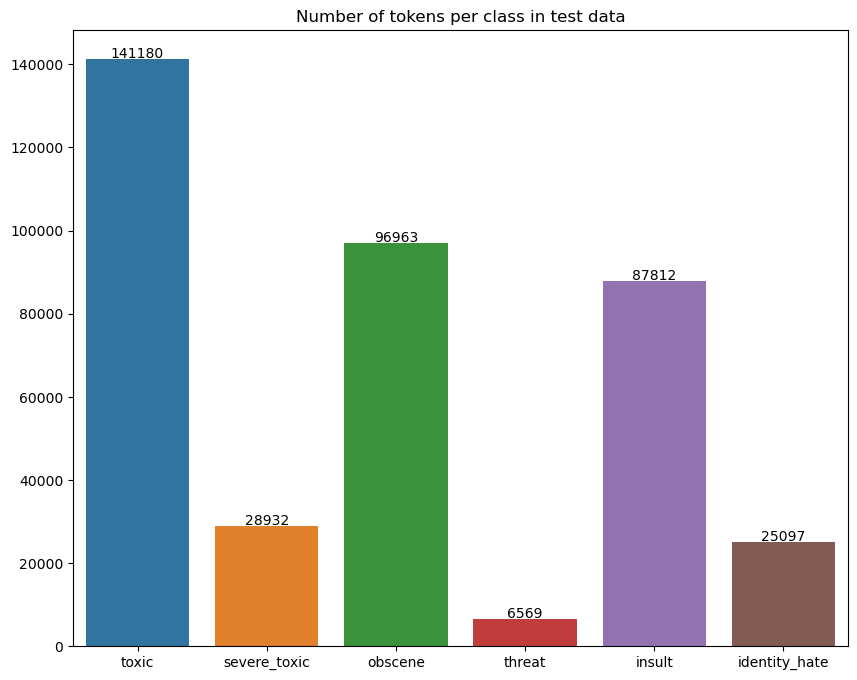

In [27]:
plot_sent(test_info, title='Number of sentences per class in test data', label_offset=200)

# Visualize the number of tokens per class
plot_tokens(test_info, title='Number of tokens per class in test data', label_offset=3000)

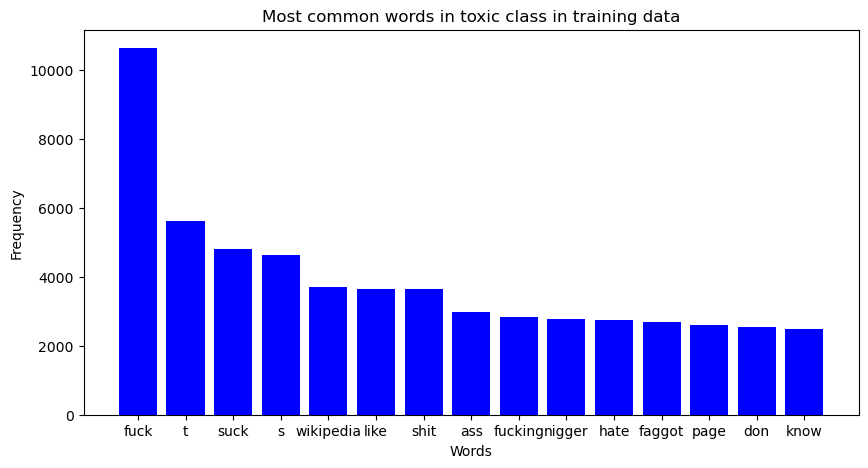

Most common words in toxic class: [('fuck', 10624), ('t', 5601), ('suck', 4801), ('s', 4633), ('wikipedia', 3688), ('like', 3657), ('shit', 3652), ('ass', 2967), ('fucking', 2822), ('nigger', 2768), ('hate', 2743), ('faggot', 2693), ('page', 2591), ('don', 2531), ('know', 2492)]


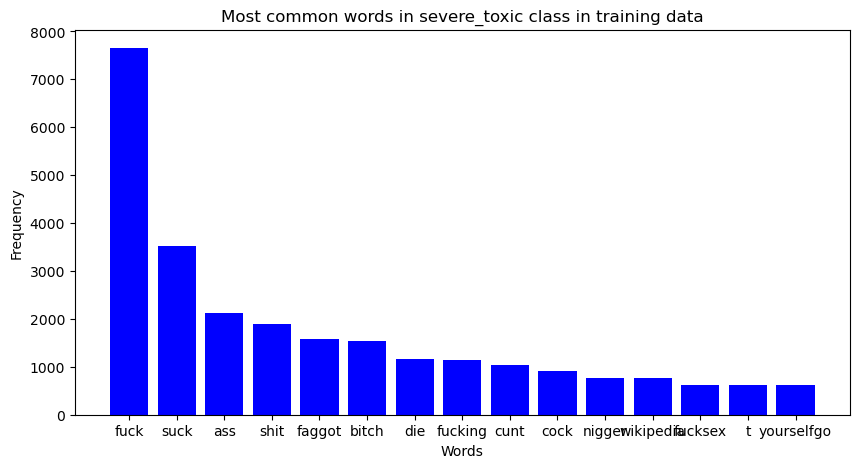

Most common words in severe_toxic class: [('fuck', 7654), ('suck', 3519), ('ass', 2119), ('shit', 1889), ('faggot', 1576), ('bitch', 1544), ('die', 1165), ('fucking', 1149), ('cunt', 1038), ('cock', 905), ('nigger', 776), ('wikipedia', 774), ('fucksex', 624), ('t', 622), ('yourselfgo', 621)]


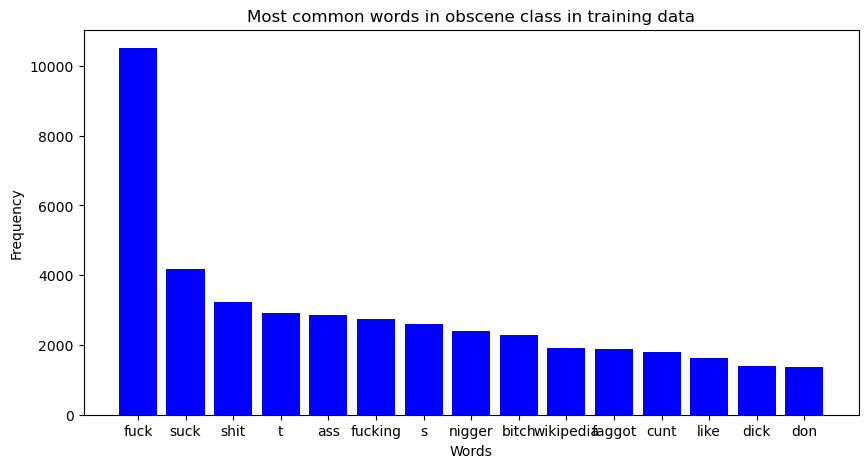

Most common words in obscene class: [('fuck', 10510), ('suck', 4191), ('shit', 3234), ('t', 2919), ('ass', 2869), ('fucking', 2738), ('s', 2611), ('nigger', 2409), ('bitch', 2281), ('wikipedia', 1912), ('faggot', 1893), ('cunt', 1784), ('like', 1634), ('dick', 1401), ('don', 1374)]


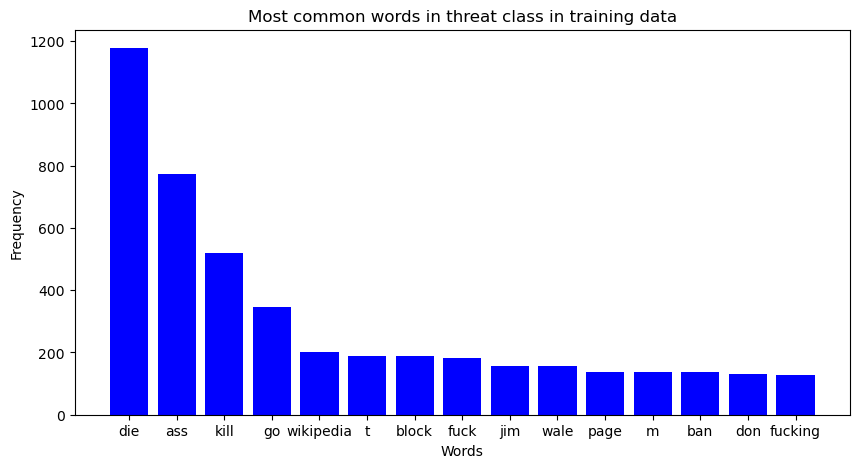

Most common words in threat class: [('die', 1178), ('ass', 772), ('kill', 521), ('go', 345), ('wikipedia', 200), ('t', 189), ('block', 188), ('fuck', 183), ('jim', 158), ('wale', 157), ('page', 138), ('m', 136), ('ban', 136), ('don', 131), ('fucking', 129)]


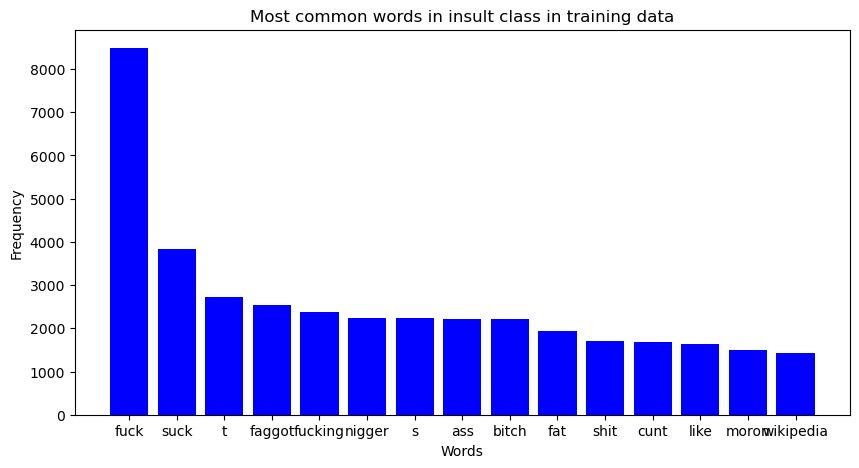

Most common words in insult class: [('fuck', 8486), ('suck', 3834), ('t', 2731), ('faggot', 2532), ('fucking', 2378), ('nigger', 2236), ('s', 2228), ('ass', 2226), ('bitch', 2209), ('fat', 1928), ('shit', 1709), ('cunt', 1689), ('like', 1644), ('moron', 1507), ('wikipedia', 1433)]


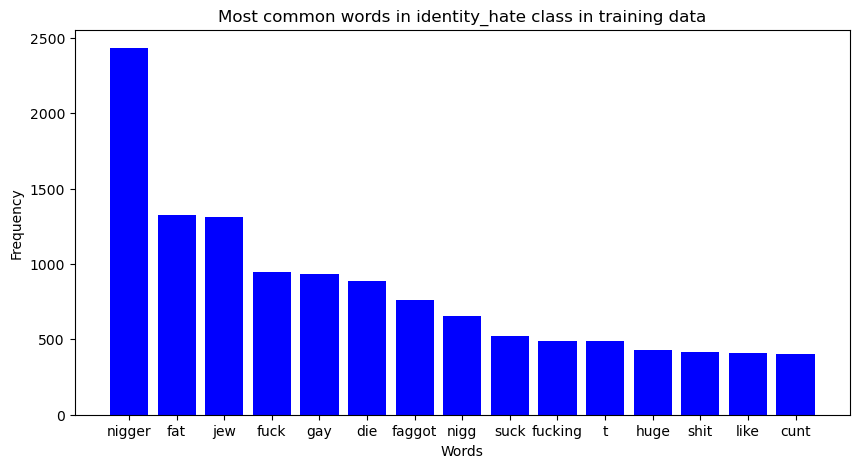

Most common words in identity_hate class: [('nigger', 2433), ('fat', 1323), ('jew', 1314), ('fuck', 946), ('gay', 936), ('die', 885), ('faggot', 761), ('nigg', 656), ('suck', 520), ('fucking', 491), ('t', 489), ('huge', 430), ('shit', 413), ('like', 409), ('cunt', 403)]


In [28]:
# Visualize the distribution of the 15 most common words for each class
for label in class_labels:
    words = []
    for comment in df_combined[df_combined[label] == 1]['comment']:
        words.extend(comment)
    most_common_words = Counter(words).most_common(15)
    plot_common_words(most_common_words, f'Most common words in {label} class in training data')
    print(f'Most common words in {label} class: {most_common_words}')
    

In [29]:
def eval_clf(clf, X_test, y_test, class_labels, name):
    y_pred = clf.predict(X_test)
    # calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc_roc = roc_auc_score(np.array(y_test), y_pred, average='macro')

    # output performance report
    out_dict = {'model': name, 'accuracy': accuracy, 'precision': precision,
                'recall': recall, 'f1': f1, 'auc_roc': auc_roc}

    # output confusion matrix
    conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

    class_report = classification_report(y_test, y_pred,
                                         target_names=class_labels, zero_division=1)

    return out_dict, class_report, conf_matrix

def plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    for cm, label, ax in zip(conf_matrix, class_labels, axs.flatten()):
        sns.heatmap(cm, annot=True, fmt='d', cmap=None, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(label)

    plt.tight_layout()
    plt.suptitle(f'Multilabel Confusion Matrix ({model_name})', y=1.02)
    plt.show()

In [30]:
# the tokenizer and preprocessing steps are identity functions
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)

# fit vectorizer on train and test data
X = vectorizer.fit_transform(df_combined['comment'])
X_test = vectorizer.transform(df_combined_test['comment'])

y = df_combined[class_labels]
y_test = df_combined_test[class_labels]

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [43]:
X.shape, y.shape, X_test.shape, y_test.shape

((159571, 100), (159571, 6), (63978, 100), (63978, 6))

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [33]:
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=0)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

# Train and test models
init_classifiers = {'SVM': svm, 'LogReg': logreg, 'DecisionTree': dt}
classifiers = {}

metrics = []
class_reports = {}
conf_matrices = {}

for key, classifier in init_classifiers.items():
    classifiers[key] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    out_dict, class_report, conf_matrix = eval_clf(classifiers[key], X_test, y_test, class_labels, key)
    metrics.append(out_dict)
    class_reports[key] = class_report
    conf_matrices[key] = conf_matrix

In [34]:
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

          model  accuracy  precision    recall        f1   auc_roc
0           SVM  0.817406   0.346736  0.753954  0.465738  0.854049
1        LogReg  0.798978   0.289181  0.893547  0.421478  0.915557
2  DecisionTree  0.780768   0.254031  0.662907  0.356062  0.802152


In [35]:
best_model_tfidf = classifiers['LogReg']

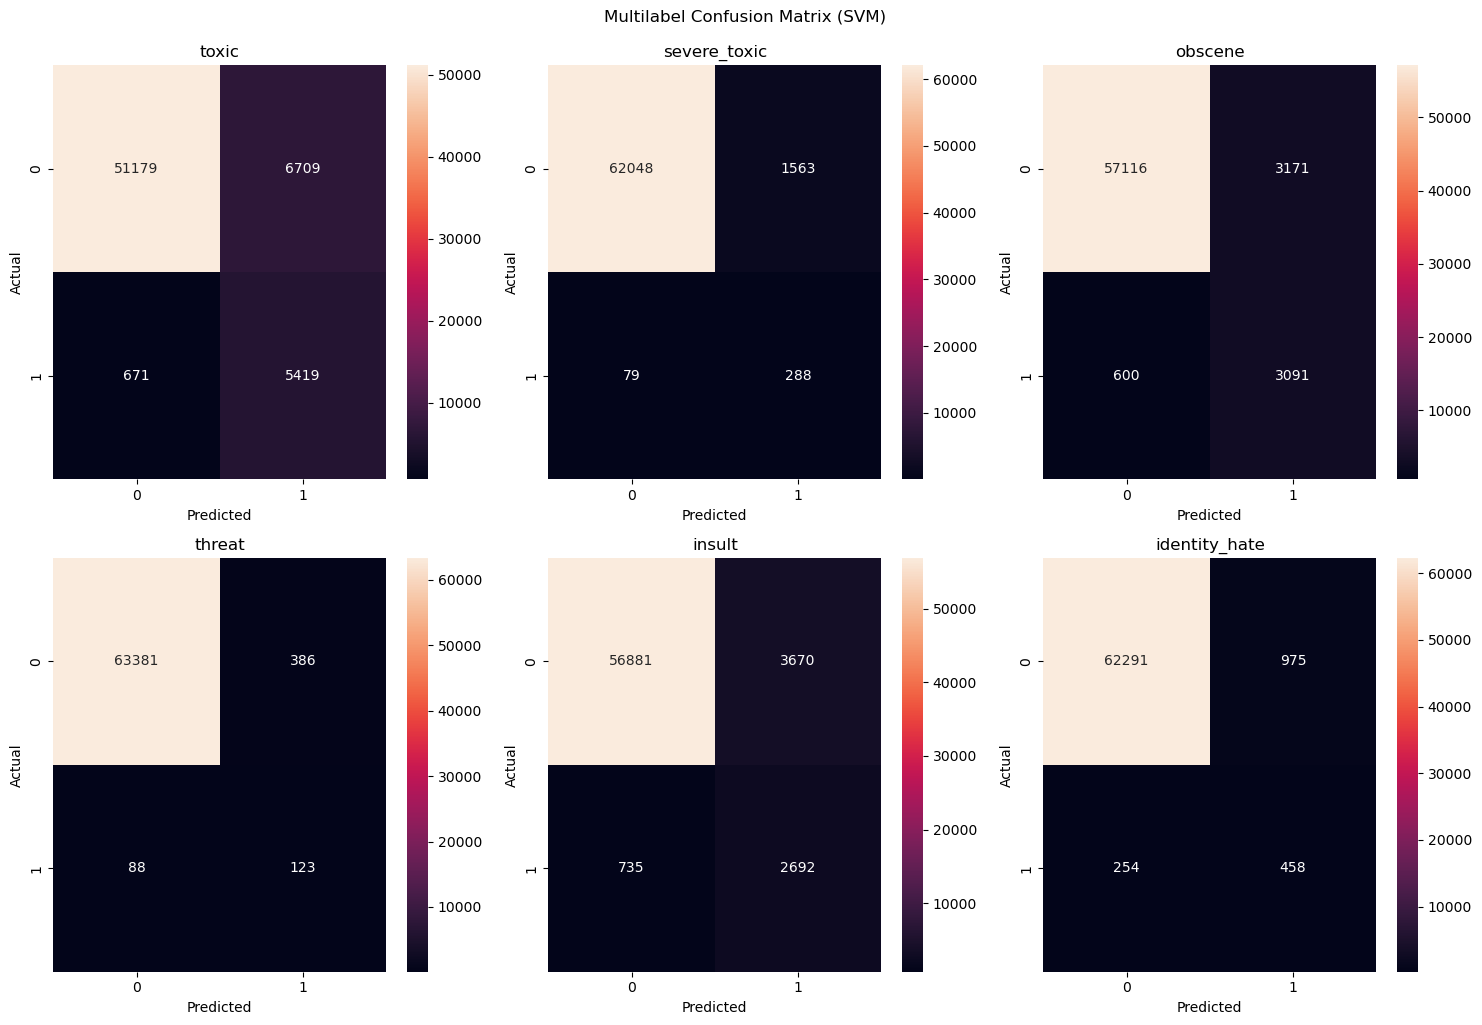

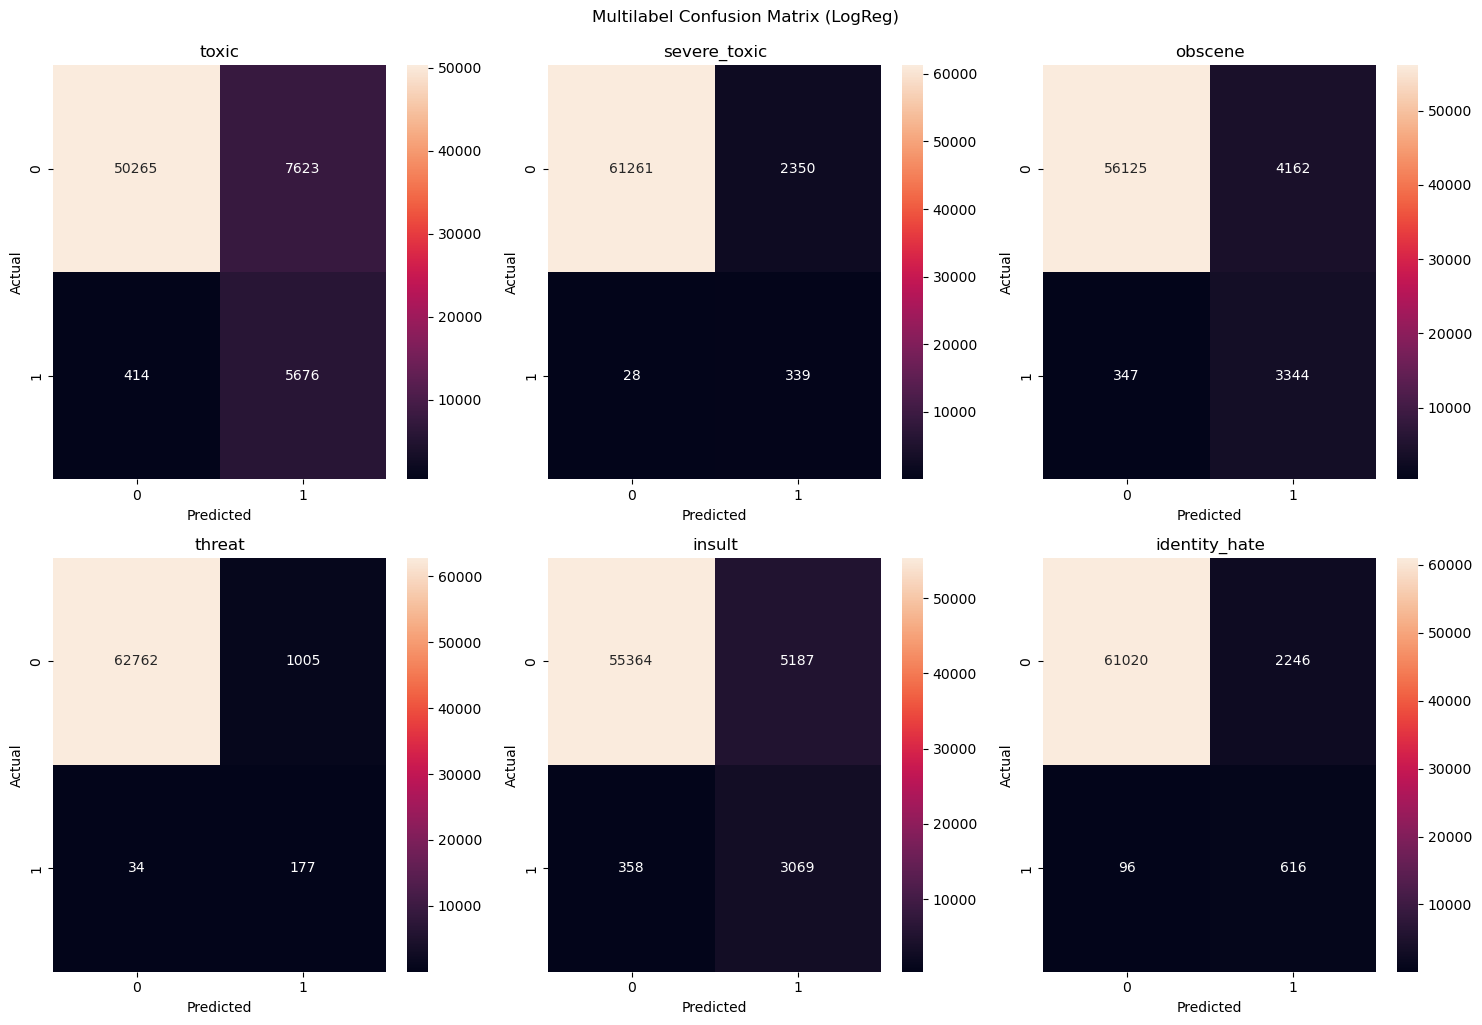

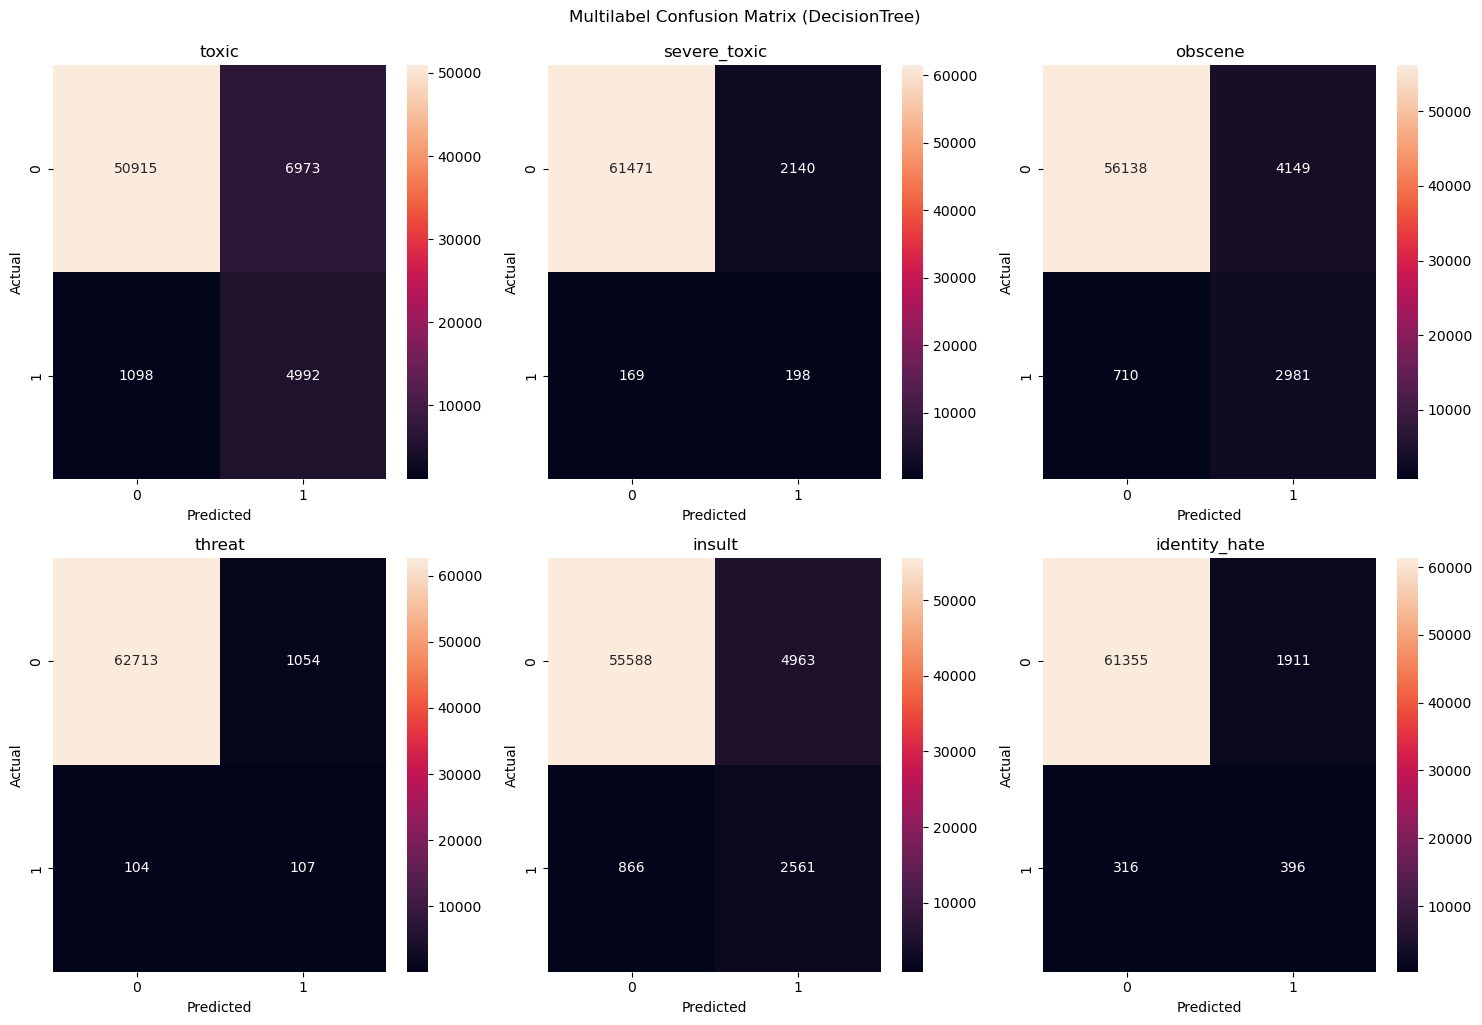

In [36]:
for model_name, conf_matrix in conf_matrices.items():
    plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name)

In [37]:
comments = df_combined['comment'].tolist()
comments_test = df_combined_test['comment'].tolist()

y = df_combined[class_labels]
y_test = df_combined_test[class_labels]

In [38]:
model = Word2Vec(sentences=comments, workers=12)
model.save('model/w2v.model')
word_vectors = model.wv

In [39]:
def get_document_vector(document_tokens):
    """
    Get document vector by averaging word vectors

    :param document_tokens: list of strings
    :return: array
    """
    document_vector = np.zeros((model.vector_size,))
    n_words = 0
    for token in document_tokens:
        if token in model.wv.key_to_index:
            document_vector += model.wv.get_vector(token)
            n_words += 1
    if n_words > 0:
        document_vector /= n_words # get average
    return document_vector

In [40]:
document_vectors_train = [get_document_vector(doc) for doc in comments]
X = np.array(document_vectors_train)

document_vectors_test = [get_document_vector(doc) for doc in comments_test]
X_test = np.array(document_vectors_test)

In [41]:
X = normalize(X)
X_test = normalize(X_test)

In [42]:
X.shape, y.shape, X_test.shape, y_test.shape

((159571, 100), (159571, 6), (63978, 100), (63978, 6))

In [44]:
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=0)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

# Train and test models
init_classifiers = {'SVM': svm, 'LogReg': logreg, 'DecisionTree': dt}
classifiers = {}

metrics = []
class_reports = {}
conf_matrices = {}

for key, classifier in init_classifiers.items():
    classifiers[key] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    out_dict, class_report, conf_matrix = eval_clf(classifiers[key], X_test, y_test, class_labels, key)
    metrics.append(out_dict)
    class_reports[key] = class_report
    conf_matrices[key] = conf_matrix

In [45]:
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

          model  accuracy  precision    recall        f1   auc_roc
0           SVM  0.738441   0.188317  0.919241  0.287392  0.899200
1        LogReg  0.737910   0.186886  0.919571  0.285999  0.898910
2  DecisionTree  0.822111   0.319038  0.404396  0.353579  0.687978


In [46]:
best_model_w2v = classifiers['SVM']

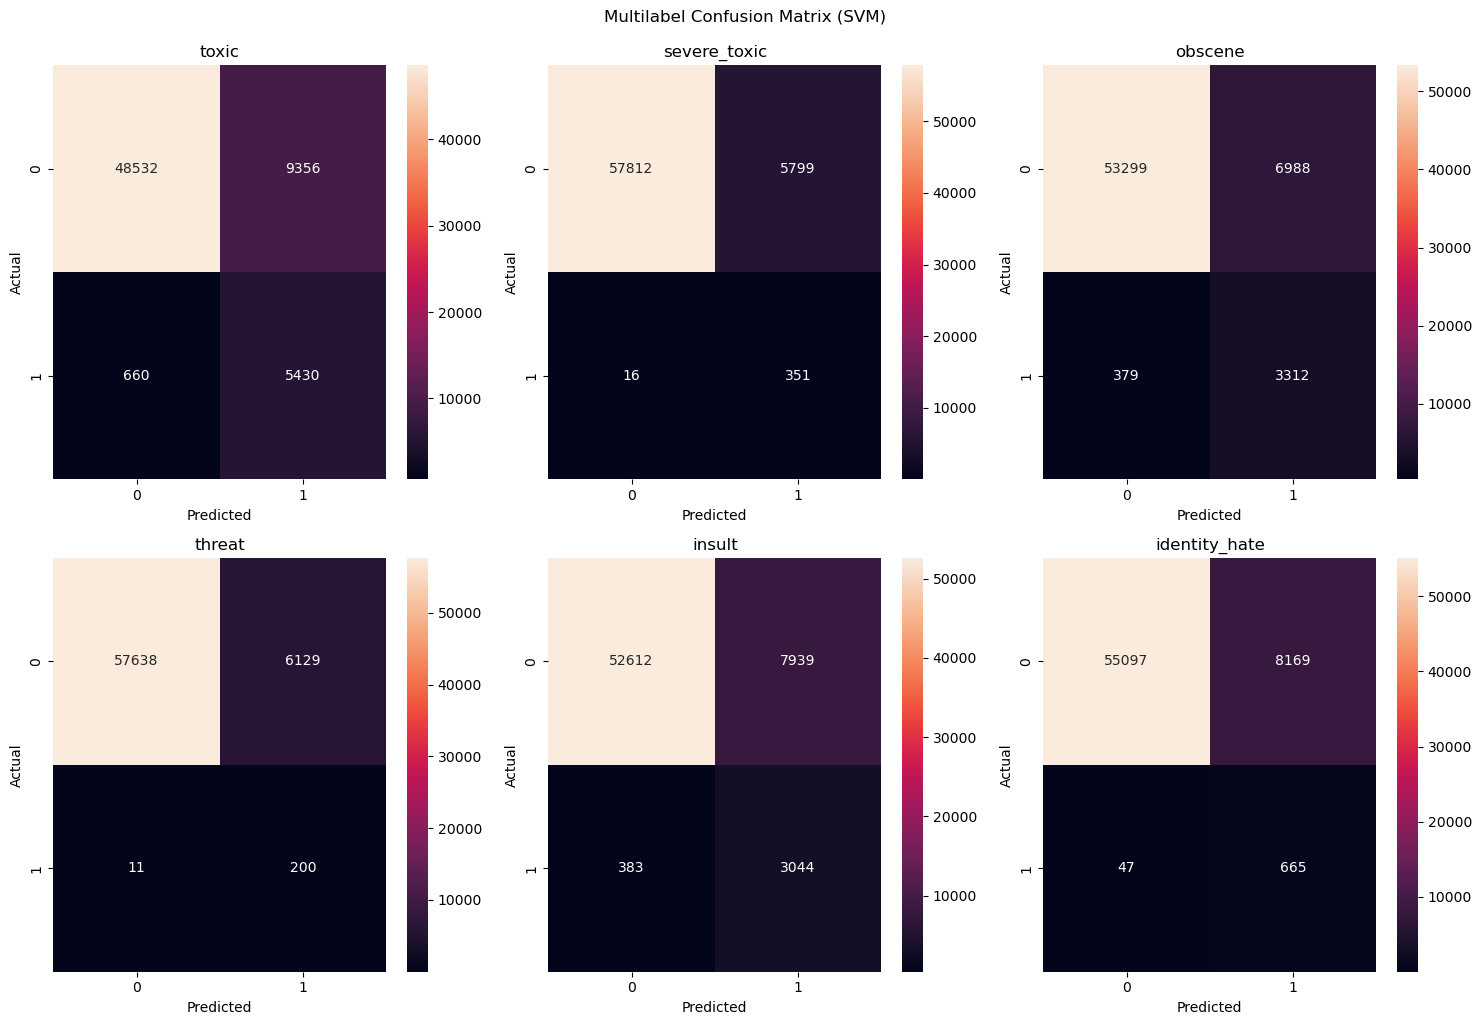

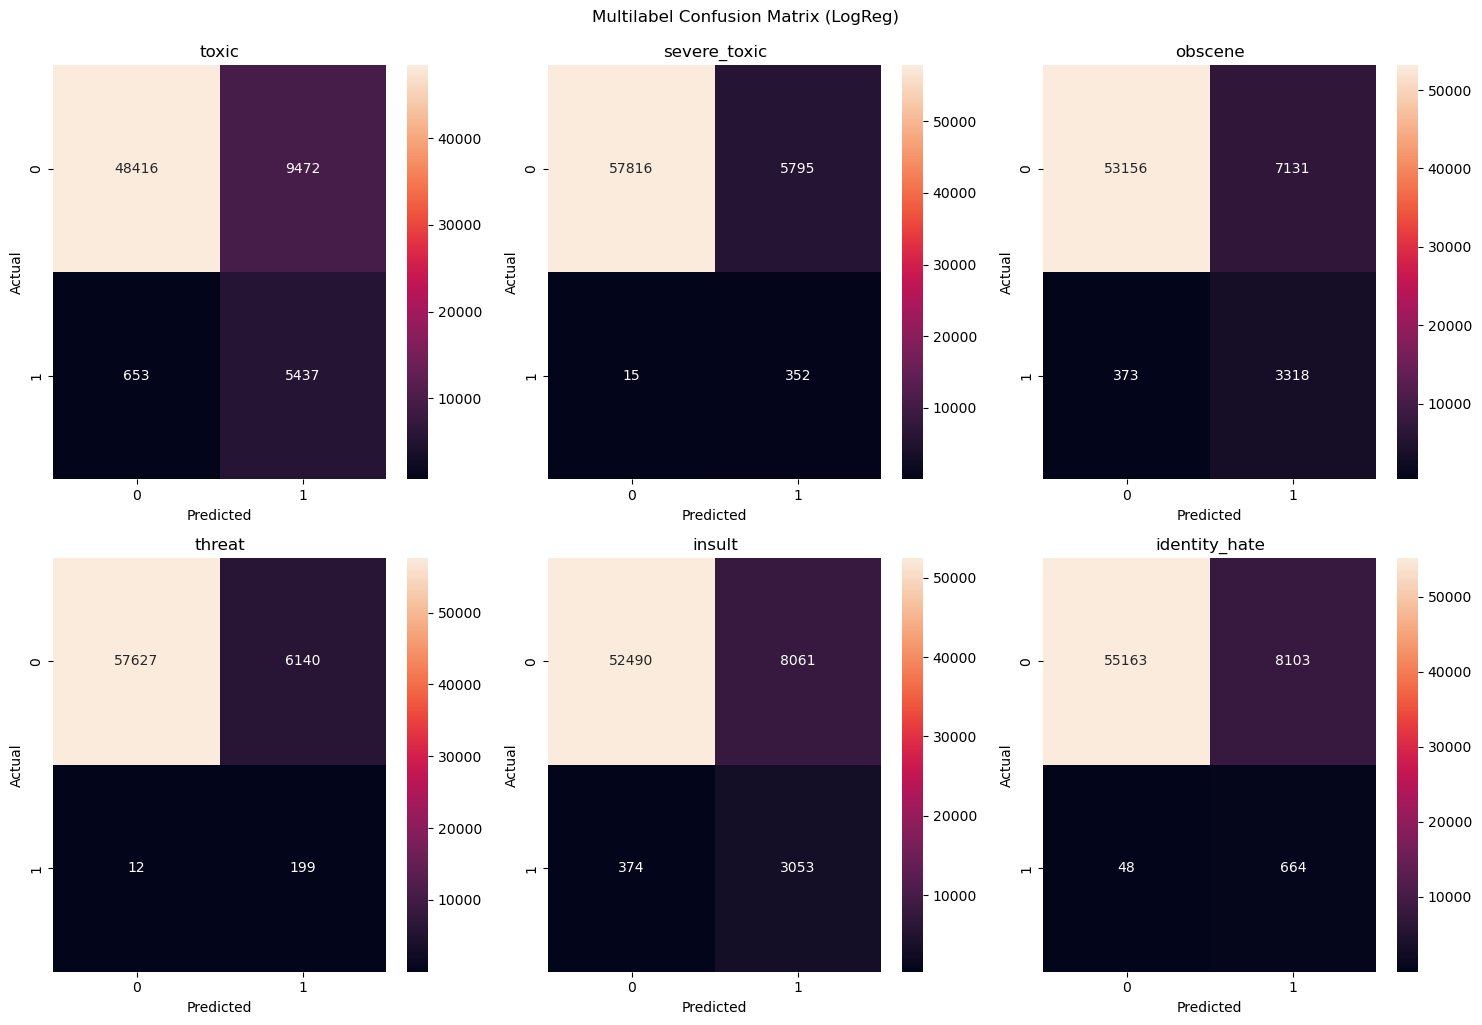

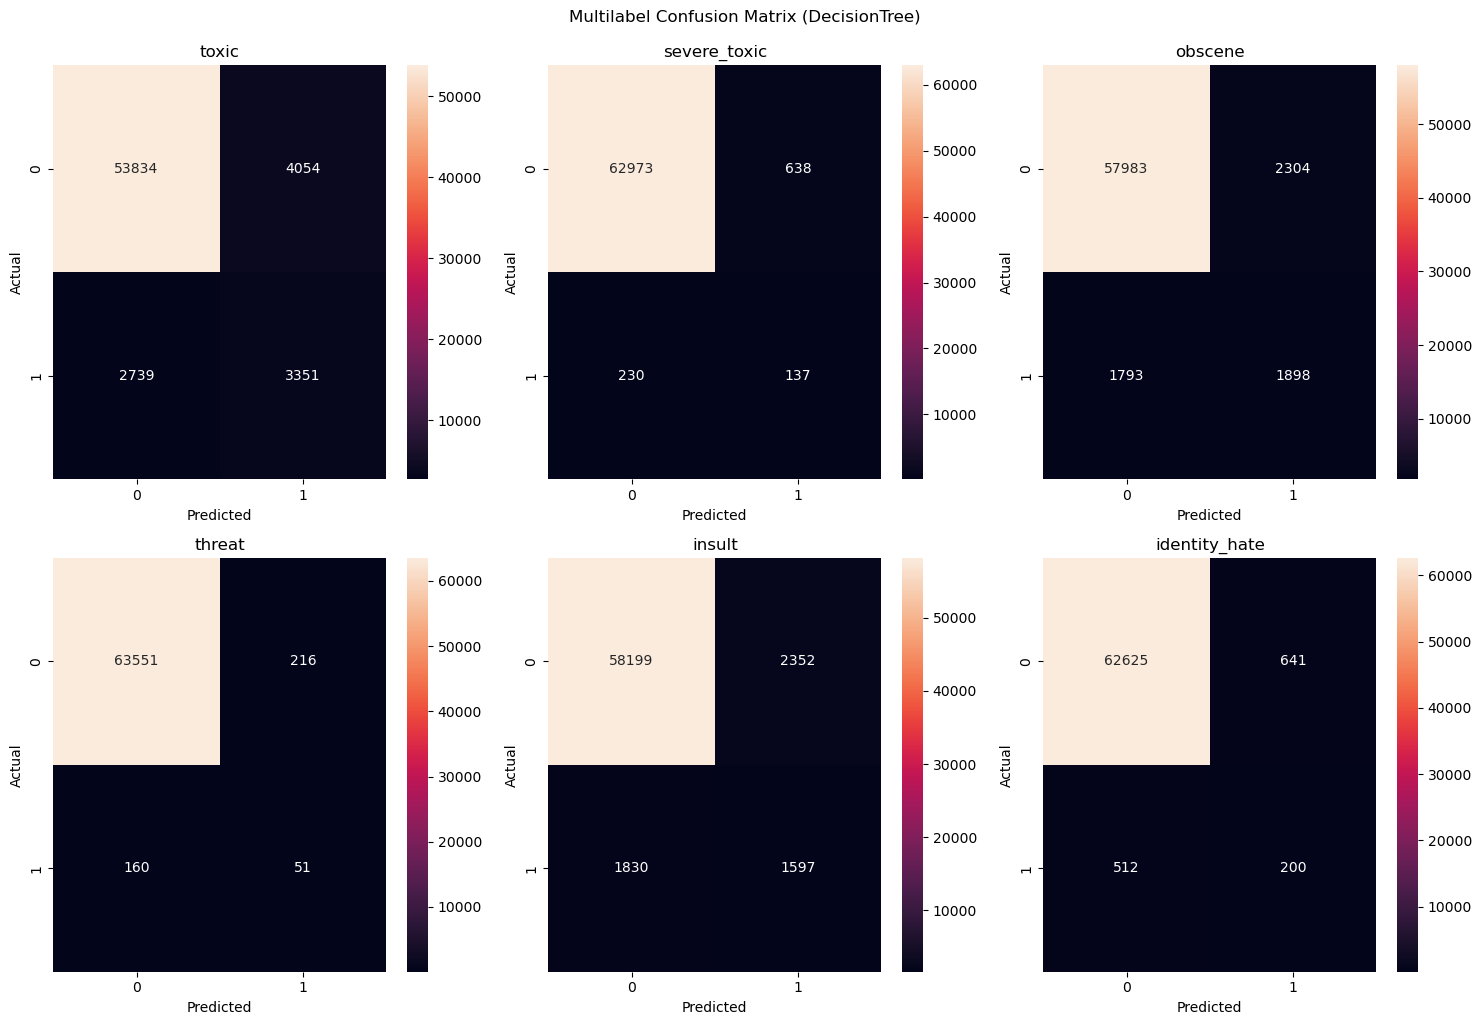

In [47]:
for model_name, conf_matrix in conf_matrices.items():
    plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name)

In [48]:
best_model = best_model_tfidf
pickle.dump(best_model, open('model/best_model.pkl', 'wb'))

In [49]:
test_data = pd.read_csv("D:\\MS sem 2\\NLP\\test.csv")
test_data.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [58]:
import pandas as pd

# Example preprocess_text function (handle lists)
def preprocess_text(text_or_list):
    if isinstance(text_or_list, list):
        # Join list elements into a single string
        text = ' '.join(text_or_list)
    else:
        text = text_or_list
    
    # Example preprocessing steps (replace with your actual preprocessing logic)
    processed_text = text.lower()  # Convert to lowercase
    return processed_text

# Example usage assuming 'test_data' is your DataFrame
test_data['comment_text'] = test_data['comment_text'].apply(preprocess_text)

In [ ]:
y_pred = best_model.predict(X_test)

# Convert predictions to dataframe
y_pred_df = pd.DataFrame(y_pred, columns=class_labels)

# Add the id column
df_output = pd.concat([test_data['id'], y_pred_df], axis=1)
df_output.head()